## 80. id番号への変更

In [1]:
import pandas as pd

DATA_PATH = "./data/news_aggregator_dataset/"

train_df = pd.read_csv(DATA_PATH + "train.txt", delimiter="\t")
valid_df = pd.read_csv(DATA_PATH + "valid.txt", delimiter="\t")
test_df = pd.read_csv(DATA_PATH + "test.txt", delimiter="\t")

print('【学習データ】')
print(train_df['CATEGORY'].value_counts())
print('【検証データ】')
print(valid_df['CATEGORY'].value_counts())
print('【評価データ】')
print(test_df['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [2]:
from collections import defaultdict
import string


d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
for text in train_df['TITLE']:
    for word in text.translate(table).split():
        d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

word2id_dict = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id_dict.values()))}\n')
print('頻度上位20語')
for key in list(word2id_dict)[:20]:
    print(f'{key}: {word2id_dict[key]}')

ID数: 9393

頻度上位20語
to: 1
s: 2
in: 3
UPDATE: 4
on: 5
as: 6
US: 7
for: 8
of: 9
The: 10
1: 11
To: 12
2: 13
the: 14
and: 15
In: 16
Of: 17
at: 18
a: 19
A: 20


In [3]:
def tokenizer(text, word2id=word2id_dict, unk=0):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return [word2id.get(word, unk) for word in text.translate(table).split()]

In [4]:
text = train_df.iloc[1, train_df.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Andrew Garfield wants Black-HispanicSpiderman
ID列: [504, 520, 638, 541, 0]


## 81. RNNによる予測

In [5]:
import torch
from torch import nn

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, device):
        hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
        return hidden

/home/morioka/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, index):
        text = self.X[index]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }

In [7]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train_df['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid_df['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test_df['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = MyDataset(train_df['TITLE'], y_train, tokenizer)
dataset_valid = MyDataset(valid_df['TITLE'], y_valid, tokenizer)
dataset_test = MyDataset(test_df['TITLE'], y_test, tokenizer)

print(f'datasetの長さ: {len(dataset_train)}')
print('dataset[index]:')
for var in dataset_train[1]:
    print(f'  {var}: {dataset_train[1][var]}')

datasetの長さ: 10684
dataset[index]:
  inputs: tensor([504, 520, 638, 541,   0])
  labels: 2


In [8]:

VOCAB_SIZE = len(set(word2id_dict.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 学習せずsoftmaxのみで出力
for i in range(10):
    X = dataset_train[i]['inputs']
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2526, 0.1059, 0.2868, 0.3547]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1617, 0.1372, 0.2318, 0.4692]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2599, 0.2670, 0.3197, 0.1534]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1622, 0.5067, 0.1863, 0.1448]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3870, 0.1696, 0.2195, 0.2239]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2029, 0.3864, 0.2016, 0.2091]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1816, 0.4235, 0.2585, 0.1364]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2426, 0.2194, 0.1564, 0.3816]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2342, 0.1803, 0.2854, 0.3001]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2313, 0.1110, 0.2329, 0.4248]], grad_fn=<SoftmaxBackward0>)


## 82. 確率的勾配降下法による学習

In [9]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)

            outputs = model(inputs)

            if criterion != None:
                loss += criterion(outputs, labels).item()

            # 正解率計算
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return loss / len(dataset), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
    model.to(device)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()

        loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'./data/checkpoints/checkpoint{epoch + 1}.pt')

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

        if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
            break

        scheduler.step()

    return {'train': log_train, 'valid': log_valid}

In [10]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.show()

In [11]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.0974, accuracy_train: 0.5395, loss_valid: 1.1179, accuracy_valid: 0.5090, 309.6095sec
epoch: 2, loss_train: 1.0038, accuracy_train: 0.6009, loss_valid: 1.0591, accuracy_valid: 0.5606, 306.0615sec
epoch: 3, loss_train: 0.8601, accuracy_train: 0.6806, loss_valid: 0.9298, accuracy_valid: 0.6602, 305.0134sec
epoch: 4, loss_train: 0.7211, accuracy_train: 0.7446, loss_valid: 0.8091, accuracy_valid: 0.7178, 302.6516sec
epoch: 5, loss_train: 0.6217, accuracy_train: 0.7762, loss_valid: 0.7380, accuracy_valid: 0.7433, 302.8692sec
epoch: 6, loss_train: 0.5551, accuracy_train: 0.7988, loss_valid: 0.7043, accuracy_valid: 0.7597, 303.8045sec
epoch: 7, loss_train: 0.4979, accuracy_train: 0.8166, loss_valid: 0.6799, accuracy_valid: 0.7650, 302.5950sec
epoch: 8, loss_train: 0.4690, accuracy_train: 0.8283, loss_valid: 0.6786, accuracy_valid: 0.7552, 305.6070sec
epoch: 9, loss_train: 0.4539, accuracy_train: 0.8336, loss_valid: 0.6811, accuracy_valid: 0.7530, 300.9334sec
epoch: 10,

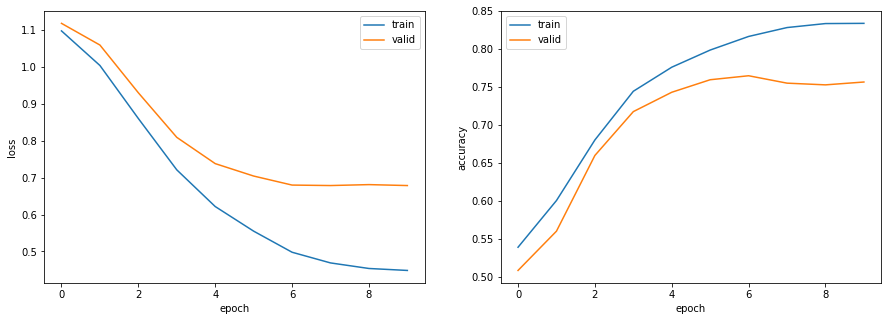

accuracy (train): 0.834
accuracy (valid): 0.753


In [12]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')

## 84. 単語ベクトルの導入

In [13]:
from gensim.models import KeyedVectors

keyed_vec = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)

VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id_dict.keys()):
  if word in keyed_vec:
    weights[i] = keyed_vec[word]
    words_in_pretrained += 1
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9164 / 9394
torch.Size([9394, 300])


In [61]:
class RNN_mod1(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, device):
        hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
        return hidden

In [15]:
class Padsequence():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

In [16]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN_mod1(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1740, accuracy_train: 0.4056, loss_valid: 1.1744, accuracy_valid: 0.4094, 108.7253sec
epoch: 2, loss_train: 1.1803, accuracy_train: 0.4236, loss_valid: 1.1783, accuracy_valid: 0.4431, 108.3137sec
epoch: 3, loss_train: 1.1622, accuracy_train: 0.4995, loss_valid: 1.1487, accuracy_valid: 0.5180, 107.7700sec
epoch: 4, loss_train: 1.0829, accuracy_train: 0.5990, loss_valid: 1.0721, accuracy_valid: 0.6018, 107.9873sec
epoch: 5, loss_train: 1.0093, accuracy_train: 0.6274, loss_valid: 1.0031, accuracy_valid: 0.6295, 107.1010sec
epoch: 6, loss_train: 0.9949, accuracy_train: 0.6384, loss_valid: 0.9992, accuracy_valid: 0.6362, 108.3231sec
epoch: 7, loss_train: 0.9972, accuracy_train: 0.6334, loss_valid: 1.0003, accuracy_valid: 0.6287, 108.3649sec
epoch: 8, loss_train: 0.9459, accuracy_train: 0.6583, loss_valid: 0.9615, accuracy_valid: 0.6475, 105.9707sec
epoch: 9, loss_train: 0.9502, accuracy_train: 0.6565, loss_valid: 0.9676, accuracy_valid: 0.6512, 107.3998sec
epoch: 10,

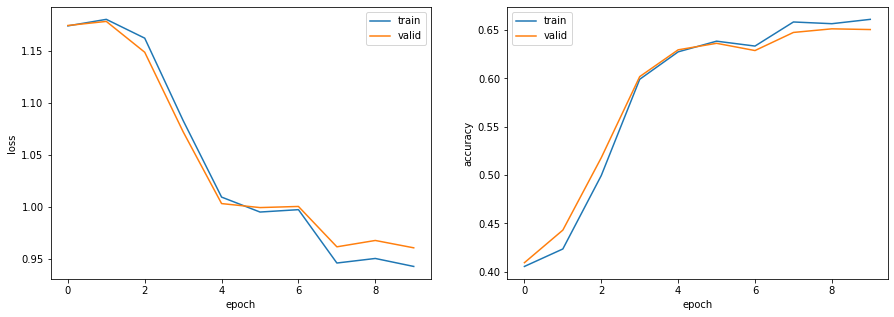

accuracy (train): 0.661
accuracy (valid): 0.651


In [17]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')

## 85. 双方向RNN・多層化

In [18]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2 #2層
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN_mod1(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True) #bidirectional:双方向でモデル作成

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1766, accuracy_train: 0.4076, loss_valid: 1.1783, accuracy_valid: 0.4072, 112.3449sec
epoch: 2, loss_train: 1.2154, accuracy_train: 0.4020, loss_valid: 1.2134, accuracy_valid: 0.4042, 112.9568sec
epoch: 3, loss_train: 1.2444, accuracy_train: 0.3966, loss_valid: 1.2413, accuracy_valid: 0.3975, 112.6263sec
epoch: 4, loss_train: 1.0429, accuracy_train: 0.6031, loss_valid: 1.0392, accuracy_valid: 0.6085, 113.6457sec
epoch: 5, loss_train: 1.0505, accuracy_train: 0.5885, loss_valid: 1.0460, accuracy_valid: 0.5838, 112.8040sec
epoch: 6, loss_train: 1.0776, accuracy_train: 0.5728, loss_valid: 1.0735, accuracy_valid: 0.5786, 113.2502sec
epoch: 7, loss_train: 0.9903, accuracy_train: 0.6267, loss_valid: 0.9994, accuracy_valid: 0.6198, 113.0350sec
epoch: 8, loss_train: 0.9643, accuracy_train: 0.6399, loss_valid: 0.9763, accuracy_valid: 0.6370, 113.4529sec
epoch: 9, loss_train: 0.9896, accuracy_train: 0.6261, loss_valid: 1.0011, accuracy_valid: 0.6190, 112.6520sec
epoch: 10,

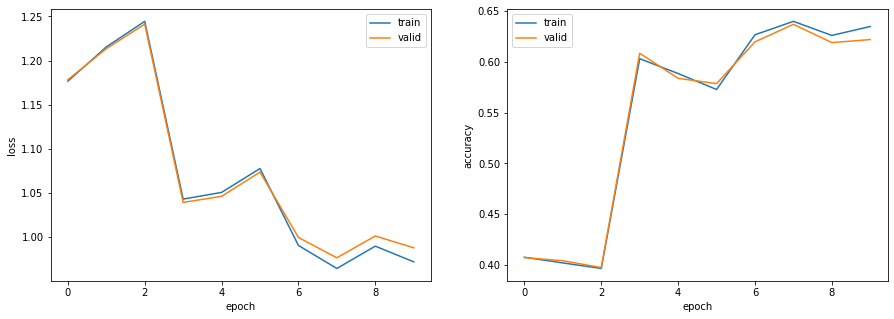

accuracy (train): 0.635
accuracy (valid): 0.629


In [19]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')

## 86. 畳み込みニューラルネットワーク(CNN)
定義のみ

In [20]:
from torch.nn import functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(out_channels, output_size)
    
    def forward(self, x):
        # x.size() = (batch_size, seq_len)
        emb = self.emb(x).unsqueeze(1)
        # emb.size() = (batch_size, 1, seq_len, emb_size)
        conv = self.conv(emb)
        # conv.size() = (batch_size, out_channels, seq_len, 1)
        act = F.relu(conv.squeeze(3))
        # act.size() = (batch_size, out_channels, seq_len)
        max_pool = F.max_pool1d(act, act.size()[2])
        # max_pool.size() = (batch_size, out_channels, 1)
        out = self.fc(self.drop(max_pool.squeeze(2)))
        # out.size() = (batch_size, output_size)
        return out

In [21]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
    X = dataset_train[i]['inputs']
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2699, 0.2784, 0.2314, 0.2203]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2638, 0.2535, 0.2381, 0.2446]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2792, 0.2717, 0.2533, 0.1959]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2577, 0.2769, 0.2299, 0.2355]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2722, 0.2512, 0.2412, 0.2354]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2725, 0.2515, 0.2308, 0.2451]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2639, 0.2776, 0.2317, 0.2268]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2788, 0.2554, 0.2399, 0.2259]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2840, 0.2700, 0.2109, 0.2351]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2678, 0.2673, 0.2333, 0.2316]], grad_fn=<SoftmaxBackward0>)


## 87. 確率的勾配降下法によるCNNの学習

In [22]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1307, accuracy_train: 0.4675, loss_valid: 1.1340, accuracy_valid: 0.4633, 104.0288sec
epoch: 2, loss_train: 1.0680, accuracy_train: 0.6440, loss_valid: 1.0792, accuracy_valid: 0.6355, 104.2551sec
epoch: 3, loss_train: 0.9830, accuracy_train: 0.6786, loss_valid: 1.0067, accuracy_valid: 0.6602, 104.2562sec
epoch: 4, loss_train: 0.9076, accuracy_train: 0.7029, loss_valid: 0.9435, accuracy_valid: 0.6751, 104.8896sec
epoch: 5, loss_train: 0.8537, accuracy_train: 0.7168, loss_valid: 0.8992, accuracy_valid: 0.6939, 103.9433sec
epoch: 6, loss_train: 0.8158, accuracy_train: 0.7285, loss_valid: 0.8698, accuracy_valid: 0.7036, 104.6210sec
epoch: 7, loss_train: 0.7915, accuracy_train: 0.7353, loss_valid: 0.8509, accuracy_valid: 0.7081, 104.0043sec
epoch: 8, loss_train: 0.7776, accuracy_train: 0.7389, loss_valid: 0.8409, accuracy_valid: 0.7133, 105.2780sec
epoch: 9, loss_train: 0.7712, accuracy_train: 0.7415, loss_valid: 0.8359, accuracy_valid: 0.7133, 104.0693sec
epoch: 10,

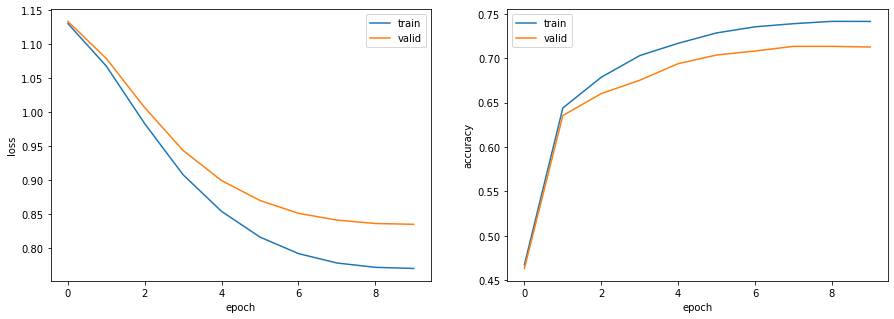

accuracy (train): 0.741
accuracy (valid): 0.698


In [23]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')

## 88. パラメータチューニング

In [69]:
import optuna

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
    momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
    batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))
    hidden_size = int(trial.suggest_discrete_uniform('hidden_size', 50, 200, 50))
    num_layers = int(trial.suggest_discrete_uniform('num_layers', 2, 4, 1))

    VOCAB_SIZE = len(set(word2id_dict.values())) + 1
    PADDING_IDX = len(set(word2id_dict.values()))
    OUTPUT_SIZE = 4
    NUM_EPOCHS = 20
    EMB_SIZE = 300

    model = RNN_mod1(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, hidden_size, num_layers, emb_weights=weights, bidirectional=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

    loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion) 

    return loss_valid

In [70]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=14400)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-06-28 01:43:19,254] A new study created in memory with name: no-name-1a1a9540-f90f-4d5a-8074-39d249a802bc
/home/morioka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/home/morioka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  """
/home/morioka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fu

epoch: 1, loss_train: 1.1677, accuracy_train: 0.3978, loss_valid: 1.1670, accuracy_valid: 0.4027, 123.2983sec
epoch: 2, loss_train: 1.1217, accuracy_train: 0.5256, loss_valid: 1.1212, accuracy_valid: 0.5157, 120.7917sec
epoch: 3, loss_train: 1.0181, accuracy_train: 0.5973, loss_valid: 1.0142, accuracy_valid: 0.5996, 120.0387sec
epoch: 4, loss_train: 0.9573, accuracy_train: 0.6526, loss_valid: 0.9701, accuracy_valid: 0.6355, 122.1190sec
epoch: 5, loss_train: 0.9946, accuracy_train: 0.6144, loss_valid: 1.0075, accuracy_valid: 0.6010, 120.3458sec
epoch: 6, loss_train: 0.9333, accuracy_train: 0.6584, loss_valid: 0.9511, accuracy_valid: 0.6392, 121.1115sec
epoch: 7, loss_train: 0.9368, accuracy_train: 0.6421, loss_valid: 0.9622, accuracy_valid: 0.6243, 121.0196sec
epoch: 8, loss_train: 0.8829, accuracy_train: 0.6635, loss_valid: 0.9120, accuracy_valid: 0.6422, 120.0087sec
epoch: 9, loss_train: 0.9461, accuracy_train: 0.6452, loss_valid: 0.9802, accuracy_valid: 0.6257, 120.9484sec
epoch: 10,

[I 2023-06-28 02:23:45,787] Trial 0 finished with value: 0.9112346109099028 and parameters: {'learning_rate': 0.0012487145614158773, 'momentum': 0.9, 'batch_size': 16.0, 'hidden_size': 200.0, 'num_layers': 3.0}. Best is trial 0 with value: 0.9112346109099028.


epoch: 1, loss_train: 1.1619, accuracy_train: 0.4289, loss_valid: 1.1621, accuracy_valid: 0.4341, 116.5524sec
epoch: 2, loss_train: 1.1631, accuracy_train: 0.4195, loss_valid: 1.1631, accuracy_valid: 0.4102, 116.5069sec
epoch: 3, loss_train: 1.1633, accuracy_train: 0.4235, loss_valid: 1.1628, accuracy_valid: 0.4139, 115.9650sec
epoch: 4, loss_train: 1.1749, accuracy_train: 0.4081, loss_valid: 1.1731, accuracy_valid: 0.4072, 115.1471sec
epoch: 5, loss_train: 1.1835, accuracy_train: 0.4306, loss_valid: 1.1823, accuracy_valid: 0.4334, 115.9770sec
epoch: 6, loss_train: 1.0685, accuracy_train: 0.5735, loss_valid: 1.0763, accuracy_valid: 0.5666, 115.0424sec
epoch: 7, loss_train: 1.0029, accuracy_train: 0.6191, loss_valid: 1.0180, accuracy_valid: 0.6093, 115.5710sec
epoch: 8, loss_train: 0.9909, accuracy_train: 0.6256, loss_valid: 0.9950, accuracy_valid: 0.6213, 115.3495sec
epoch: 9, loss_train: 0.9750, accuracy_train: 0.6321, loss_valid: 0.9980, accuracy_valid: 0.6153, 115.4220sec
epoch: 10,

[I 2023-06-28 03:02:36,401] Trial 1 finished with value: 0.9542200914667752 and parameters: {'learning_rate': 0.006176954921487048, 'momentum': 0.8, 'batch_size': 64.0, 'hidden_size': 50.0, 'num_layers': 3.0}. Best is trial 0 with value: 0.9112346109099028.


epoch: 1, loss_train: 1.1640, accuracy_train: 0.4206, loss_valid: 1.1642, accuracy_valid: 0.4124, 118.8587sec
epoch: 2, loss_train: 1.1642, accuracy_train: 0.4101, loss_valid: 1.1644, accuracy_valid: 0.4027, 119.1330sec
epoch: 3, loss_train: 1.1659, accuracy_train: 0.4052, loss_valid: 1.1659, accuracy_valid: 0.4004, 119.1854sec
epoch: 4, loss_train: 1.1641, accuracy_train: 0.4200, loss_valid: 1.1638, accuracy_valid: 0.4259, 118.7934sec
epoch: 5, loss_train: 1.1716, accuracy_train: 0.4012, loss_valid: 1.1704, accuracy_valid: 0.4019, 118.2566sec
epoch: 6, loss_train: 1.1736, accuracy_train: 0.4086, loss_valid: 1.1704, accuracy_valid: 0.4079, 119.0273sec
epoch: 7, loss_train: 1.2029, accuracy_train: 0.3999, loss_valid: 1.1944, accuracy_valid: 0.3990, 118.9501sec


[I 2023-06-28 03:16:41,640] Trial 2 finished with value: 1.1943859257428588 and parameters: {'learning_rate': 0.004468441176770839, 'momentum': 0.8, 'batch_size': 96.0, 'hidden_size': 100.0, 'num_layers': 4.0}. Best is trial 0 with value: 0.9112346109099028.


epoch: 1, loss_train: 1.2063, accuracy_train: 0.4190, loss_valid: 1.2079, accuracy_valid: 0.4311, 111.6333sec
epoch: 2, loss_train: 1.1682, accuracy_train: 0.4159, loss_valid: 1.1701, accuracy_valid: 0.4237, 112.2182sec
epoch: 3, loss_train: 1.1645, accuracy_train: 0.4182, loss_valid: 1.1664, accuracy_valid: 0.4199, 112.9456sec
epoch: 4, loss_train: 1.1632, accuracy_train: 0.4173, loss_valid: 1.1652, accuracy_valid: 0.4162, 112.1955sec
epoch: 5, loss_train: 1.1632, accuracy_train: 0.4165, loss_valid: 1.1652, accuracy_valid: 0.4184, 111.1678sec
epoch: 6, loss_train: 1.1629, accuracy_train: 0.4172, loss_valid: 1.1649, accuracy_valid: 0.4169, 112.8663sec
epoch: 7, loss_train: 1.1627, accuracy_train: 0.4174, loss_valid: 1.1648, accuracy_valid: 0.4229, 112.3619sec
epoch: 8, loss_train: 1.1627, accuracy_train: 0.4186, loss_valid: 1.1648, accuracy_valid: 0.4214, 112.3801sec
epoch: 9, loss_train: 1.1628, accuracy_train: 0.4183, loss_valid: 1.1649, accuracy_valid: 0.4207, 112.0075sec
epoch: 10,

[I 2023-06-28 03:35:38,375] Trial 3 finished with value: 1.16490323560502 and parameters: {'learning_rate': 0.0008125991472757116, 'momentum': 0.8, 'batch_size': 80.0, 'hidden_size': 100.0, 'num_layers': 2.0}. Best is trial 0 with value: 0.9112346109099028.


epoch: 1, loss_train: 1.1920, accuracy_train: 0.4221, loss_valid: 1.1938, accuracy_valid: 0.4207, 109.7284sec
epoch: 2, loss_train: 1.1630, accuracy_train: 0.4207, loss_valid: 1.1654, accuracy_valid: 0.4192, 113.5278sec
epoch: 3, loss_train: 1.1612, accuracy_train: 0.4214, loss_valid: 1.1637, accuracy_valid: 0.4199, 113.0912sec
epoch: 4, loss_train: 1.1609, accuracy_train: 0.4213, loss_valid: 1.1634, accuracy_valid: 0.4169, 111.9898sec
epoch: 5, loss_train: 1.1608, accuracy_train: 0.4195, loss_valid: 1.1633, accuracy_valid: 0.4222, 107.2773sec
epoch: 6, loss_train: 1.1608, accuracy_train: 0.4189, loss_valid: 1.1634, accuracy_valid: 0.4169, 111.9642sec
epoch: 7, loss_train: 1.1606, accuracy_train: 0.4196, loss_valid: 1.1632, accuracy_valid: 0.4139, 112.2490sec
epoch: 8, loss_train: 1.1605, accuracy_train: 0.4189, loss_valid: 1.1632, accuracy_valid: 0.4154, 112.7256sec
epoch: 9, loss_train: 1.1606, accuracy_train: 0.4174, loss_valid: 1.1633, accuracy_valid: 0.4124, 111.6244sec
epoch: 10,

[I 2023-06-28 04:03:52,209] Trial 4 finished with value: 1.1633239533908353 and parameters: {'learning_rate': 0.0009054258875957542, 'momentum': 0.8, 'batch_size': 80.0, 'hidden_size': 150.0, 'num_layers': 2.0}. Best is trial 0 with value: 0.9112346109099028.


epoch: 1, loss_train: 1.1657, accuracy_train: 0.4229, loss_valid: 1.1689, accuracy_valid: 0.4222, 121.5367sec
epoch: 2, loss_train: 1.1771, accuracy_train: 0.3990, loss_valid: 1.1796, accuracy_valid: 0.4004, 125.1864sec
epoch: 3, loss_train: 1.1774, accuracy_train: 0.4001, loss_valid: 1.1786, accuracy_valid: 0.3975, 128.0728sec
epoch: 4, loss_train: 1.2087, accuracy_train: 0.3977, loss_valid: 1.2064, accuracy_valid: 0.3945, 116.0707sec
epoch: 5, loss_train: 1.2439, accuracy_train: 0.3975, loss_valid: 1.2370, accuracy_valid: 0.3967, 115.4115sec
epoch: 6, loss_train: 1.1289, accuracy_train: 0.5085, loss_valid: 1.1209, accuracy_valid: 0.5067, 117.4332sec
epoch: 7, loss_train: 1.0679, accuracy_train: 0.5798, loss_valid: 1.0648, accuracy_valid: 0.5801, 123.7511sec
epoch: 8, loss_train: 1.1030, accuracy_train: 0.5485, loss_valid: 1.0944, accuracy_valid: 0.5472, 115.6796sec
epoch: 9, loss_train: 0.9739, accuracy_train: 0.6364, loss_valid: 0.9757, accuracy_valid: 0.6467, 135.9323sec
epoch: 10,

[I 2023-06-28 04:43:59,651] Trial 5 finished with value: 0.9655457789323734 and parameters: {'learning_rate': 0.010486375987360923, 'momentum': 0.7, 'batch_size': 64.0, 'hidden_size': 50.0, 'num_layers': 3.0}. Best is trial 0 with value: 0.9112346109099028.


epoch: 1, loss_train: 1.1750, accuracy_train: 0.3958, loss_valid: 1.1751, accuracy_valid: 0.4004, 116.5627sec
epoch: 2, loss_train: 1.1495, accuracy_train: 0.4733, loss_valid: 1.1425, accuracy_valid: 0.4798, 116.1085sec
epoch: 3, loss_train: 1.1322, accuracy_train: 0.5159, loss_valid: 1.1197, accuracy_valid: 0.5247, 115.9005sec
epoch: 4, loss_train: 1.2622, accuracy_train: 0.3826, loss_valid: 1.2512, accuracy_valid: 0.3975, 116.3118sec
epoch: 5, loss_train: 1.2496, accuracy_train: 0.4436, loss_valid: 1.2371, accuracy_valid: 0.4491, 115.3047sec
epoch: 6, loss_train: 1.1087, accuracy_train: 0.5414, loss_valid: 1.1058, accuracy_valid: 0.5389, 116.1841sec
epoch: 7, loss_train: 1.2643, accuracy_train: 0.4897, loss_valid: 1.2535, accuracy_valid: 0.4910, 116.2835sec
epoch: 8, loss_train: 1.2037, accuracy_train: 0.4761, loss_valid: 1.2053, accuracy_valid: 0.4738, 115.4033sec
epoch: 9, loss_train: 1.0360, accuracy_train: 0.5825, loss_valid: 1.0473, accuracy_valid: 0.5763, 116.2228sec
epoch: 10,

[I 2023-06-28 05:23:05,585] Trial 6 finished with value: 1.252309798908526 and parameters: {'learning_rate': 0.026246972379642772, 'momentum': 0.8, 'batch_size': 80.0, 'hidden_size': 150.0, 'num_layers': 3.0}. Best is trial 0 with value: 0.9112346109099028.


epoch: 1, loss_train: 1.1706, accuracy_train: 0.4179, loss_valid: 1.1696, accuracy_valid: 0.4237, 115.5648sec
epoch: 2, loss_train: 1.1651, accuracy_train: 0.4171, loss_valid: 1.1643, accuracy_valid: 0.4192, 115.6981sec
epoch: 3, loss_train: 1.1641, accuracy_train: 0.4173, loss_valid: 1.1633, accuracy_valid: 0.4192, 115.3765sec
epoch: 4, loss_train: 1.1635, accuracy_train: 0.4212, loss_valid: 1.1628, accuracy_valid: 0.4259, 115.4033sec
epoch: 5, loss_train: 1.1633, accuracy_train: 0.4225, loss_valid: 1.1626, accuracy_valid: 0.4409, 115.1529sec
epoch: 6, loss_train: 1.1630, accuracy_train: 0.4247, loss_valid: 1.1623, accuracy_valid: 0.4364, 115.2038sec
epoch: 7, loss_train: 1.1634, accuracy_train: 0.4228, loss_valid: 1.1626, accuracy_valid: 0.4364, 114.8818sec
epoch: 8, loss_train: 1.1631, accuracy_train: 0.4214, loss_valid: 1.1624, accuracy_valid: 0.4311, 114.7134sec
epoch: 9, loss_train: 1.1632, accuracy_train: 0.4207, loss_valid: 1.1625, accuracy_valid: 0.4289, 114.2355sec
epoch: 10,

[I 2023-06-28 05:55:53,353] Trial 7 finished with value: 1.1623430664757055 and parameters: {'learning_rate': 0.002583184083245428, 'momentum': 0.7, 'batch_size': 128.0, 'hidden_size': 100.0, 'num_layers': 3.0}. Best is trial 0 with value: 0.9112346109099028.


Best trial:
  Value: 0.911
  Params: 
    learning_rate: 0.0012487145614158773
    momentum: 0.9
    batch_size: 16.0
    hidden_size: 200.0
    num_layers: 3.0


Best trial:
  Value: 0.911
  Params: 
    learning_rate: 0.0012487145614158773
    momentum: 0.9
    batch_size: 16.0
    hidden_size: 200.0
    num_layers: 3.0

In [71]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 200
NUM_LAYERS = 3
LEARNING_RATE = 0.0012487145614158773
BATCH_SIZE = 16
NUM_EPOCHS = 20

model = RNN_mod1(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True) #bidirectional:双方向でモデル作成

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1760, accuracy_train: 0.3960, loss_valid: 1.1793, accuracy_valid: 0.3952, 121.4011sec
epoch: 2, loss_train: 1.1311, accuracy_train: 0.4879, loss_valid: 1.1284, accuracy_valid: 0.5000, 120.4357sec
epoch: 3, loss_train: 1.0219, accuracy_train: 0.5914, loss_valid: 1.0244, accuracy_valid: 0.5883, 121.4564sec
epoch: 4, loss_train: 0.9634, accuracy_train: 0.6384, loss_valid: 0.9776, accuracy_valid: 0.6295, 120.7269sec
epoch: 5, loss_train: 0.9422, accuracy_train: 0.6411, loss_valid: 0.9604, accuracy_valid: 0.6340, 121.0694sec
epoch: 6, loss_train: 0.9665, accuracy_train: 0.6165, loss_valid: 0.9823, accuracy_valid: 0.6070, 120.5892sec
epoch: 7, loss_train: 0.9044, accuracy_train: 0.6413, loss_valid: 0.9368, accuracy_valid: 0.6332, 120.1659sec
epoch: 8, loss_train: 0.9391, accuracy_train: 0.6179, loss_valid: 0.9638, accuracy_valid: 0.6085, 120.5240sec
epoch: 9, loss_train: 0.8976, accuracy_train: 0.6483, loss_valid: 0.9309, accuracy_valid: 0.6392, 119.8880sec
epoch: 10,

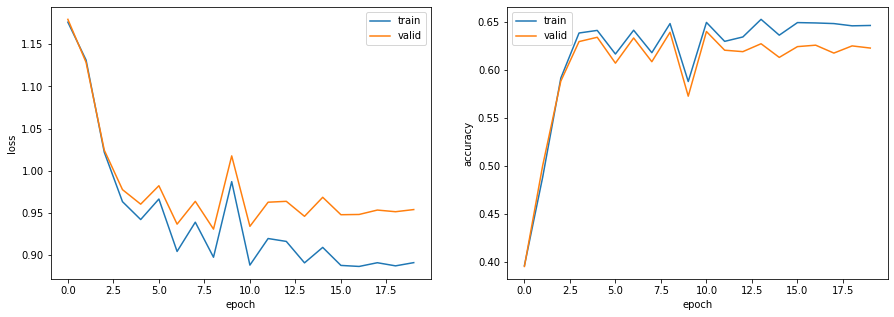

accuracy (train): 0.646
accuracy (valid): 0.632


In [72]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')

## 89. 事前学習済みモデルから転移学習

In [73]:
from transformers import BertTokenizer, BertModel

class PTMDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        text = self.X[index]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.LongTensor(ids),
            'mask': torch.LongTensor(mask),
            'labels': torch.Tensor(self.y[index])
        }

In [74]:
y_train = pd.get_dummies(train_df, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid_df, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test_df, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pmt_dataset_train = PTMDataset(train_df['TITLE'], y_train, tokenizer, max_len)
pmt_dataset_valid = PTMDataset(valid_df['TITLE'], y_valid, tokenizer, max_len)
pmt_dataset_test = PTMDataset(test_df['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
    print(f'{var}: {dataset_train[0][var]}')

Downloading: 100%|██████████| 226k/226k [00:00<00:00, 855kB/s] 
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 33.7kB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 299kB/s]

inputs: tensor([3551, 2649, 6648, 3552,    2, 4239,    1, 1885,   19, 1724])
labels: 0


In [75]:
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, otuput_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = torch.nn.Dropout(drop_rate)
        self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定
    
    def forward(self, ids, mask):
        _, out = self.bert(ids, attention_mask=mask, return_dict=False)
        out = self.fc(self.drop(out))
        return out

In [76]:
def calculate_loss_and_accuracy_bert(model, criterion, loader, device):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(ids, mask)

            loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
            labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
            total += len(labels)
            correct += (pred == labels).sum().item()
    return loss / len(loader), correct / total

def train_bert_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):

    model.to(device)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        for data in dataloader_train:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_train, acc_train = calculate_loss_and_accuracy_bert(model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy_bert(model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    return {'train': log_train, 'valid': log_valid}

In [78]:
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

model = BERTClass(DROP_RATE, OUTPUT_SIZE)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

log = train_bert_model(pmt_dataset_train, pmt_dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 1, loss_train: 0.0860, accuracy_train: 0.9527, loss_valid: 0.1196, accuracy_valid: 0.9259, 65.3948sec
epoch: 2, loss_train: 0.0510, accuracy_train: 0.9700, loss_valid: 0.1135, accuracy_valid: 0.9192, 65.8645sec
epoch: 3, loss_train: 0.0265, accuracy_train: 0.9892, loss_valid: 0.0951, accuracy_valid: 0.9371, 65.5370sec
epoch: 4, loss_train: 0.0180, accuracy_train: 0.9929, loss_valid: 0.1095, accuracy_valid: 0.9319, 65.7775sec


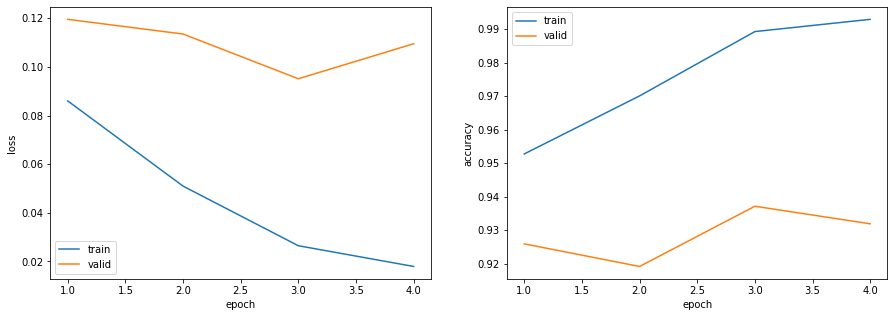

In [79]:
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [81]:
# 正解率の算出
def calculate_bert_accuracy(model, dataset, device):
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model.forward(ids, mask)
            pred = torch.argmax(outputs, dim=-1).cpu().numpy()
            labels = torch.argmax(labels, dim=-1).cpu().numpy()
            total += len(labels)
            correct += (pred == labels).sum().item()

    return correct / total

print(f'正解率（学習データ）：{calculate_bert_accuracy(model, pmt_dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_bert_accuracy(model, pmt_dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_bert_accuracy(model, pmt_dataset_test, device):.3f}')

RuntimeError: CUDA out of memory. Tried to allocate 628.00 MiB (GPU 0; 23.65 GiB total capacity; 3.90 GiB already allocated; 621.12 MiB free; 4.13 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF